In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)

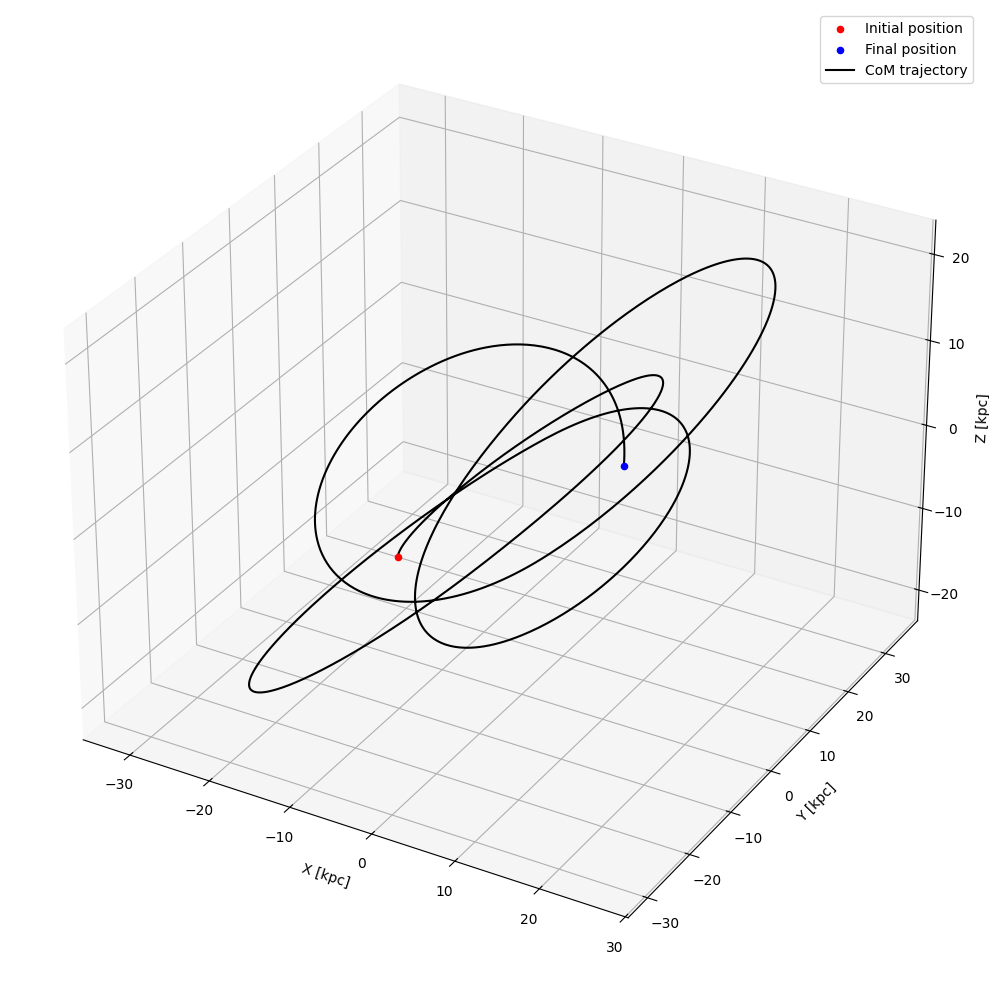

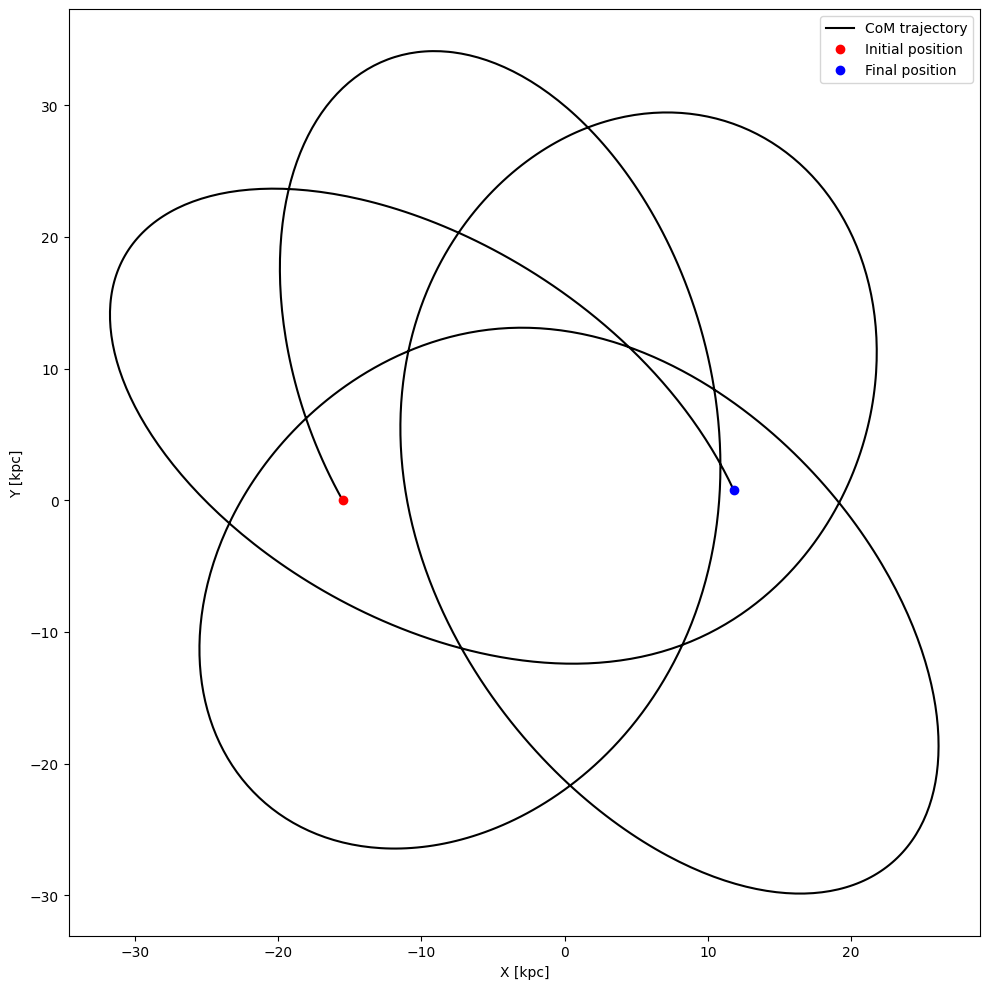

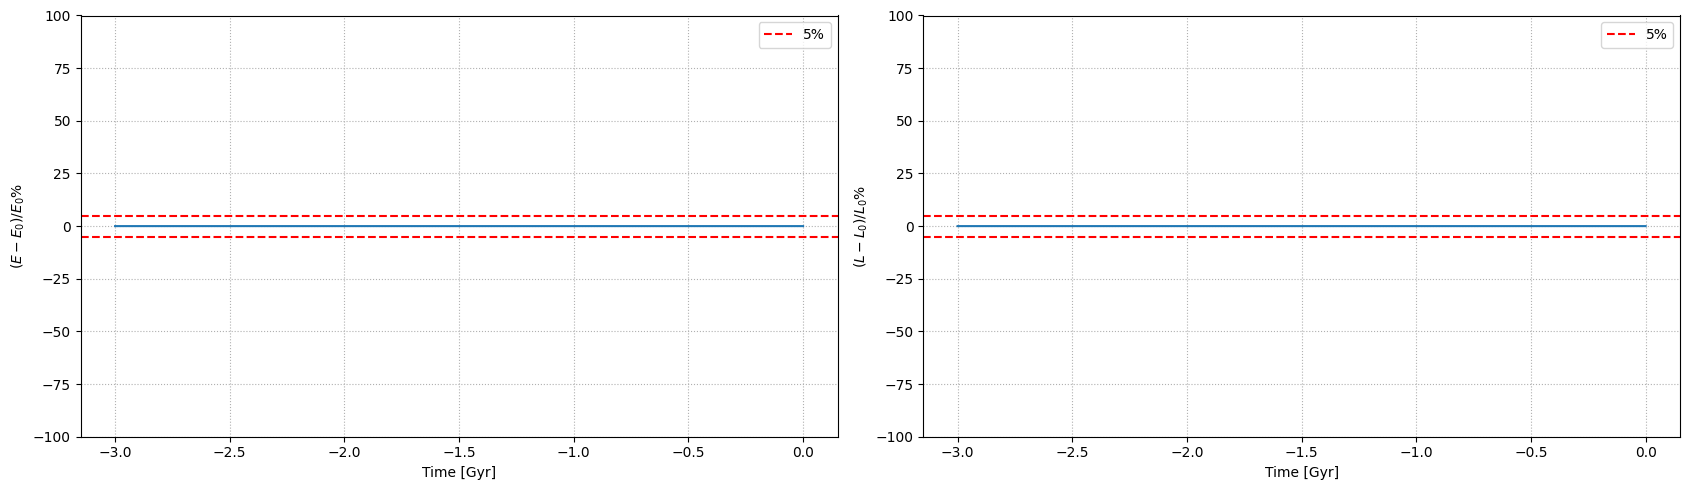

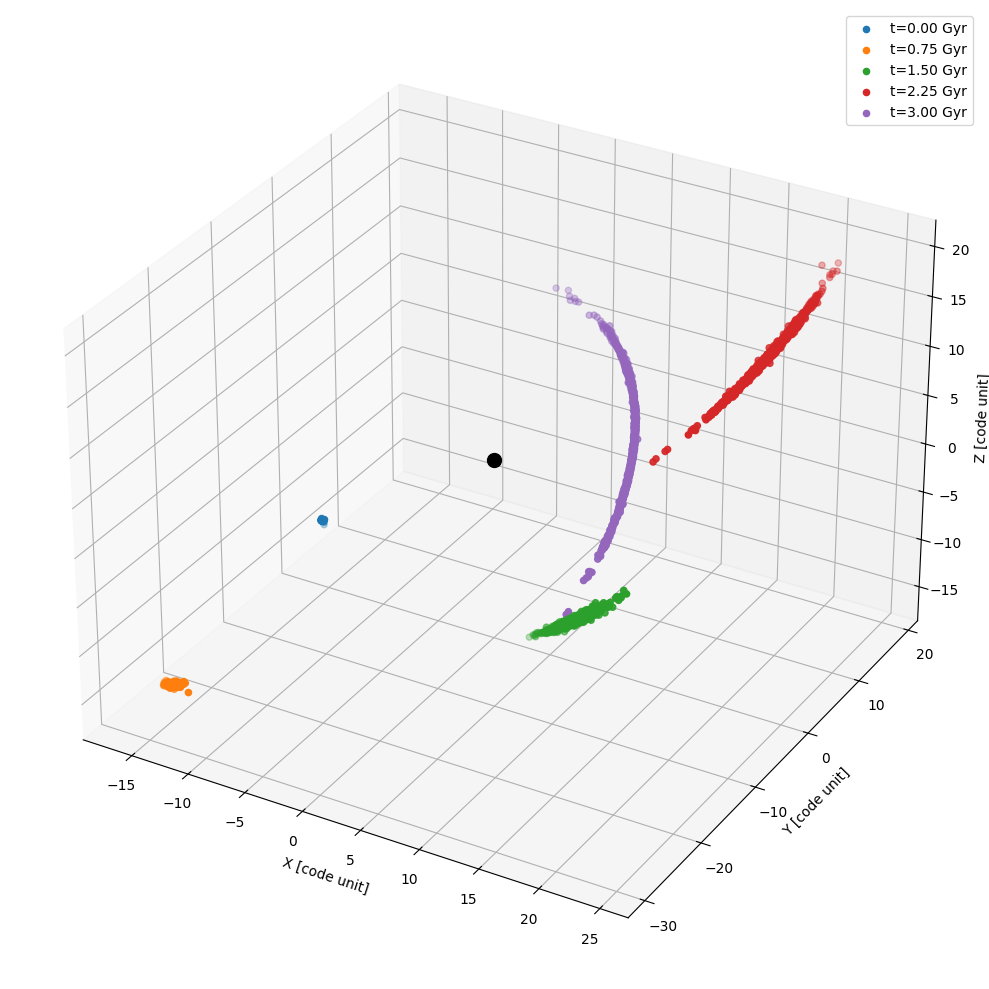

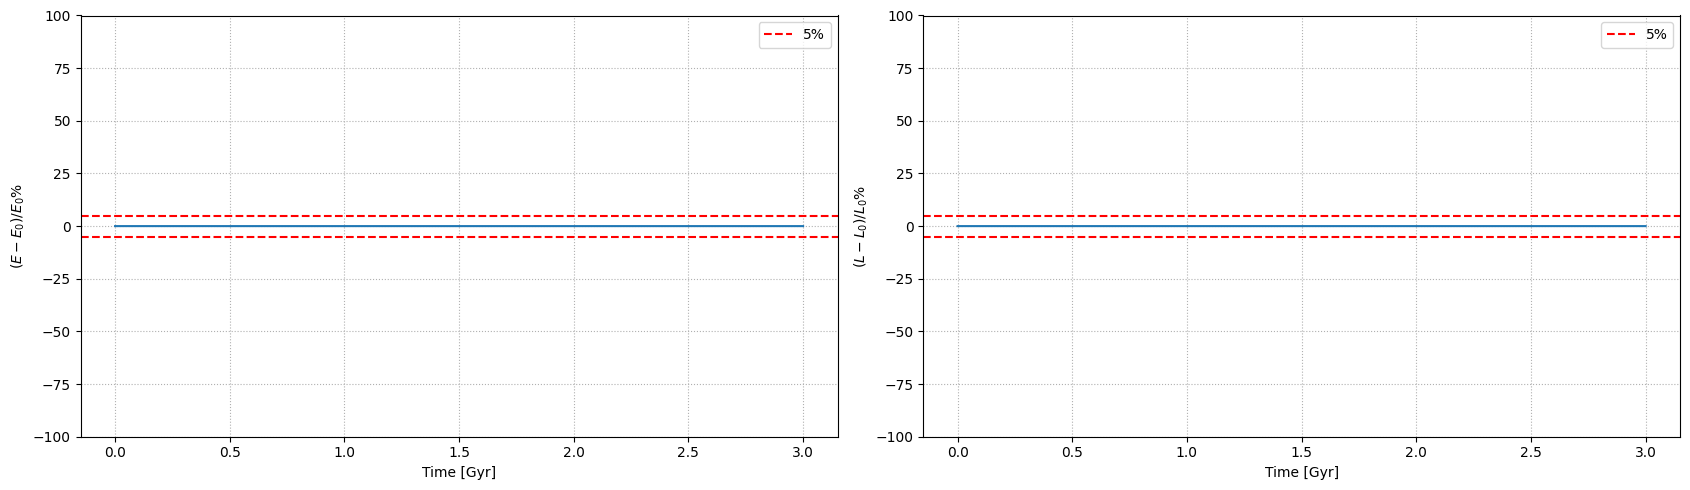

In [3]:
##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

##### Stream orbit plot####
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [11]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1000, 
#                          softening = (0.1 * u.pc).to(code_units.code_length).value,
#                          )

config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )

@jit
def time_integration_NFW_mass_grad(Mvir,):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    snapshots_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)

    states_com = snapshots_com.states
    stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

    mask = stream_data[:, 1]>stream_coordinate_com[0, :, 1]
    interp_stream_track = jnp.interp(stream_data[:, 1], stream_coordinate_com[:50, :, 1].ravel(), stream_coordinate_com[:50, :, 2].ravel())
    #we compute the chi2 loss only on the part of the stream that is trailing the cluster
    # chi2 = jnp.sum((stream_data[:, 2][stream_data[:, 1]>stream_coordinate_com[0, :, 1]] - interp_stream_track)**2 / 0.1**2)
    chi2 = jnp.sum((jnp.where(mask, stream_data[:, 2] - interp_stream_track, 0))**2 / 0.1**2)
    return states_com
    # return chi2


states_com = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir)




In [12]:
states_com

Array([[[[ 1.1800001e+00,  7.9000004e-02,  6.4000005e-01],
         [ 3.3596096e+01, -7.8084076e+01, -2.7705275e+01]]],


       [[[ 1.1452003e+00,  1.5705706e-01,  6.6696262e-01],
         [ 3.5926304e+01, -7.7847366e+01, -2.6154322e+01]]],


       [[[ 1.1080930e+00,  2.3479737e-01,  6.9233924e-01],
         [ 3.8203915e+01, -7.7451187e+01, -2.4538031e+01]]],


       ...,


       [[[-1.6108203e+00,  1.2362204e-01, -1.2050639e+00],
         [-2.8734005e+01,  6.1053040e+01, -2.1395611e+01]]],


       [[[-1.5813780e+00,  6.2464155e-02, -1.1830994e+00],
         [-3.0096983e+01,  6.1132320e+01, -2.2494362e+01]]],


       [[[-1.5505555e+00,  1.2521348e-03, -1.1600208e+00],
         [-3.1491726e+01,  6.1160500e+01, -2.3621294e+01]]]],      dtype=float32)

In [13]:
states_com.shape

(1000, 1, 2, 3)

In [14]:
stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

In [15]:
stream_coordinate_com.shape

(1000, 1, 6)

In [16]:
stream_coordinate_com[:50, :, 2].shape

(50, 1)

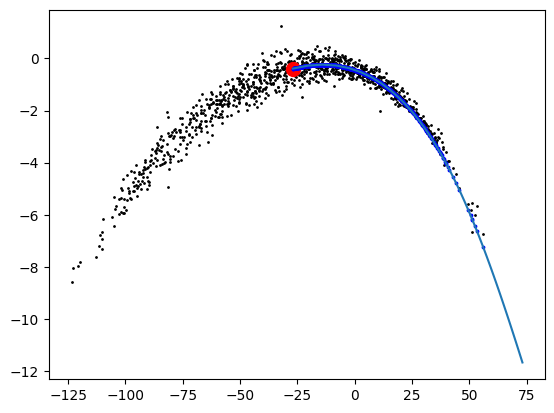

In [17]:

plt.scatter(stream_data[:, 1], stream_data[:, 2], s=1, c='k')
plt.scatter(stream_coordinate_com[0, :, 1], stream_coordinate_com[0, :, 2], s=100, c='r')
plt.plot(stream_coordinate_com[:50, :, 1], stream_coordinate_com[:50, :, 2], )

interp_stream_track = jnp.interp(stream_data[:, 1][stream_data[:, 1]>stream_coordinate_com[0, :, 1]], stream_coordinate_com[:50, :, 1].ravel(), stream_coordinate_com[:50, :, 2].ravel())
plt.scatter(stream_data[:, 1][stream_data[:, 1]>stream_coordinate_com[0, :, 1]], interp_stream_track, s=3, c='b')

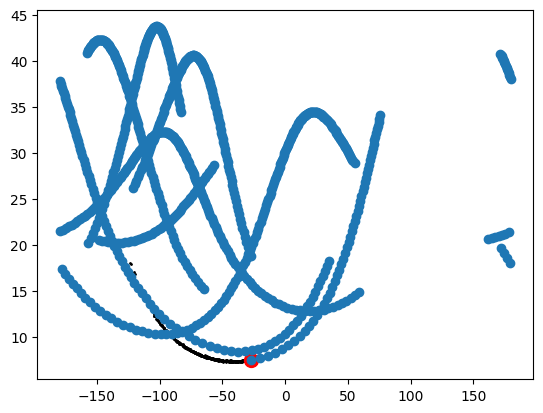

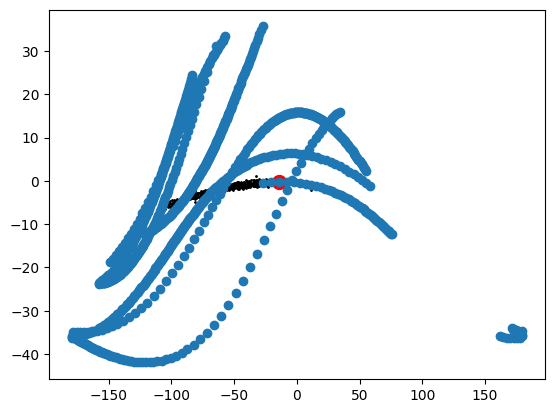

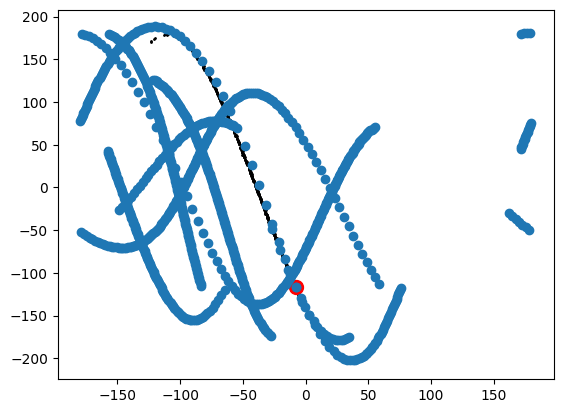

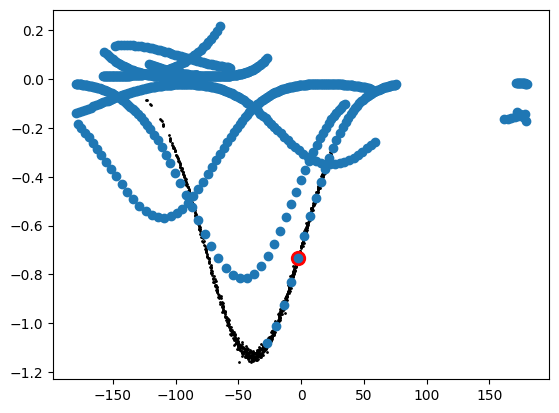

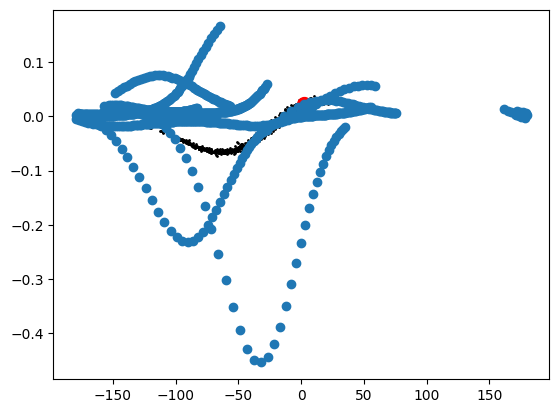

In [18]:
for i in [0, 2, 3, 4, 5]:
    plt.scatter(stream_data[:, 1], stream_data[:, i], s=1, c='k')
    plt.scatter(stream_coordinate_com[i, :, 1], stream_coordinate_com[i, :, i], s=100, c='r')
    plt.scatter(stream_coordinate_com[:, :, 1], stream_coordinate_com[:, :, i], )
    plt.show()

In [ ]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1000, 
#                          softening = (0.1 * u.pc).to(code_units.code_length).value,
#                          )

config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )

@jit
def time_integration_NFW_mass_grad(Mvir,):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    snapshots_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)

    states_com = snapshots_com.states
    stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

    mask = stream_data[:, 1]>stream_coordinate_com[0, :, 1]
    interp_stream_track = jnp.interp(
        stream_data[:, 1], 
        stream_coordinate_com[:30, :, 1].ravel(), 
        stream_coordinate_com[:30, :, 2].ravel()
    )
    
    # Calculate residuals only for valid points
    residuals = jnp.where(mask, stream_data[:, 2] - interp_stream_track, 0.0)
    n_valid = jnp.sum(mask)  # Number of valid data points
    sigma = 0.1  # Assumed observational uncertainty
    # Gaussian log-likelihood: ln L = -0.5 * [chi2 + N*ln(2π*σ²)]
    chi2 = jnp.sum(residuals**2) / sigma**2
    log_likelihood = -0.5 * (chi2 + n_valid * jnp.log(2 * jnp.pi * sigma**2))
    
    return jnp.log10(-log_likelihood)


chi2 = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir*0.8)

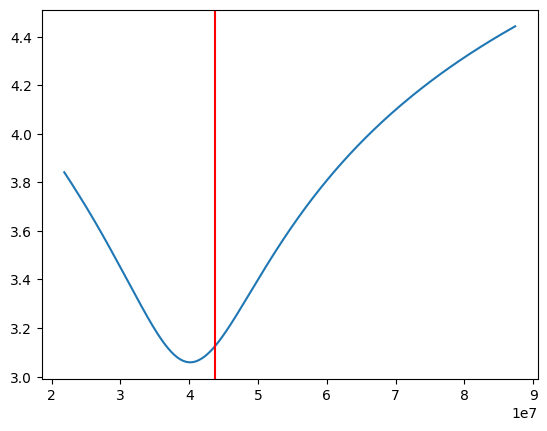

In [14]:
Mvir = jnp.linspace(params.NFW_params.Mvir*0.5, params.NFW_params.Mvir*2, 999)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir)
plt.plot(Mvir, chi2)
plt.axvline(params.NFW_params.Mvir, color='r')
# plt.ylim(-100000, 100000)

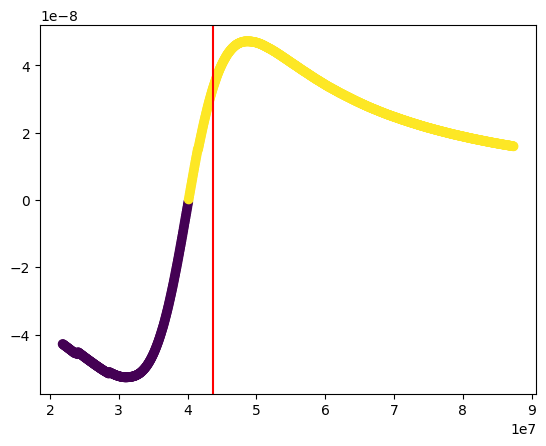

In [15]:
plt.scatter(Mvir, grad, c=grad>0)
plt.axvline(params.NFW_params.Mvir, color='r')


In [35]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1000, 
#                          softening = (0.1 * u.pc).to(code_units.code_length).value,
#                          )

config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )

from functools import partial
@partial(jit, static_argnames=['coord_indices'])
def time_integration_NFW_mass_grad(Mvir,coord_indices=jnp.array([2, 3, 4, 5])):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    snapshots_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)

    states_com = snapshots_com.states
    stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

    mask = stream_data[:, 1]>stream_coordinate_com[0, :, 1]
    n_valid = jnp.sum(mask)
    # Vectorized interpolation for all coordinates at once
    def interpolate_coord(coord_idx):
        return jnp.interp(
            stream_data[:, 1], 
            stream_coordinate_com[:30, :, 1].ravel(), 
            stream_coordinate_com[:30, :, coord_idx].ravel()
        )
    
    # Apply interpolation to all coordinates
    interp_tracks = jax.vmap(interpolate_coord)(coord_indices)  # Shape: (n_coords, n_data)
    
    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    residuals = jnp.where(mask[None, :], (data_coords - interp_tracks)/sigma[:, None], 0.0)
    
    total_chi2 = jnp.sum(residuals**2) 
    
    # Proper log-likelihood calculation
    n_coords = len(coord_indices)
    
    # Method 1: Full normalization (recommended)
    log_norm_term = -0.5 * n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * total_chi2 + log_norm_term
    
    return log_likelihood


chi2 = time_integration_NFW_mass_grad(Mvir=params.NFW_params.Mvir*0.8)

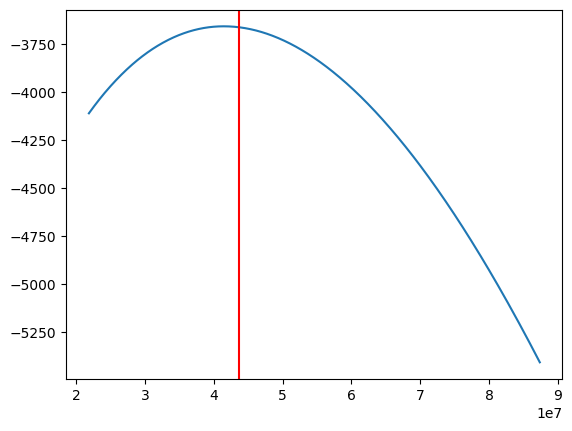

In [36]:
Mvir = jnp.linspace(params.NFW_params.Mvir*0.5, params.NFW_params.Mvir*2, 999)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir)
plt.plot(Mvir, chi2)
plt.axvline(params.NFW_params.Mvir, color='r')
# plt.ylim(-100000, 100000)

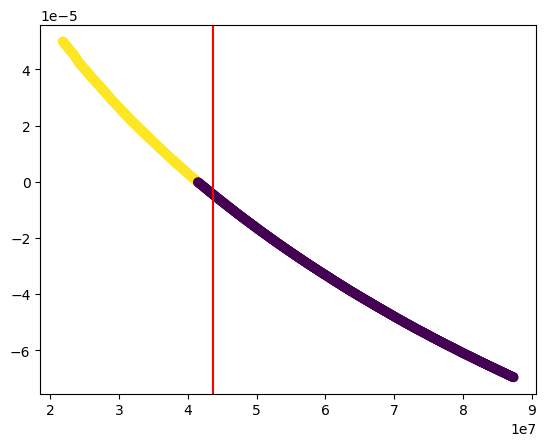

In [37]:
plt.scatter(Mvir, grad, c=grad>0)
plt.axvline(params.NFW_params.Mvir, color='r')


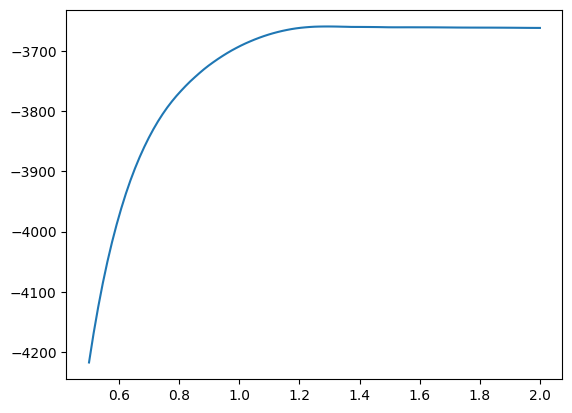

In [ ]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         )

config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )
params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

from functools import partial
@partial(jit, static_argnames=['coord_indices'])
def time_integration_tend_grad(tend,coord_indices=jnp.array([2, 3, 4, 5])):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                t_end=tend)
    new_params_com = params._replace(
                t_end=-tend)
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    snapshots_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)

    states_com = snapshots_com.states
    stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

    mask = stream_data[:, 1]>stream_coordinate_com[0, :, 1]
    n_valid = jnp.sum(mask)
    # Vectorized interpolation for all coordinates at once
    def interpolate_coord(coord_idx):
        return jnp.interp(
            stream_data[:, 1], 
            stream_coordinate_com[:20, :, 1].ravel(), 
            stream_coordinate_com[:20, :, coord_idx].ravel()
        )
    
    # Apply interpolation to all coordinates
    interp_tracks = jax.vmap(interpolate_coord)(coord_indices)  # Shape: (n_coords, n_data)
    
    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    residuals = jnp.where(mask[None, :], (data_coords - interp_tracks)/sigma[:, None], 0.0)
    
    total_chi2 = jnp.sum(residuals**2) 
    
    # Proper log-likelihood calculation
    n_coords = len(coord_indices)
    
    # Method 1: Full normalization (recommended)
    log_norm_term = -0.5 * n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * total_chi2 + log_norm_term

    
    return log_likelihood


chi2 = time_integration_tend_grad(tend=params.t_end*0.8)
tend = jnp.linspace(params.t_end*0.5, params.t_end*2, 99)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_tend_grad))(tend)
plt.plot(tend, chi2)
# plt.axvline(tend, color='r')
# plt.ylim(-10, 100)

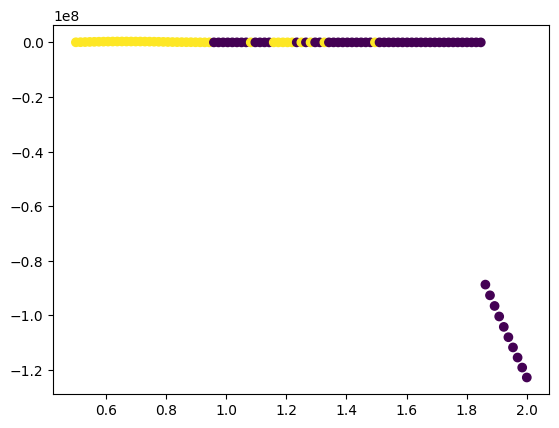

In [25]:
plt.scatter(tend, grad, c=grad>0)

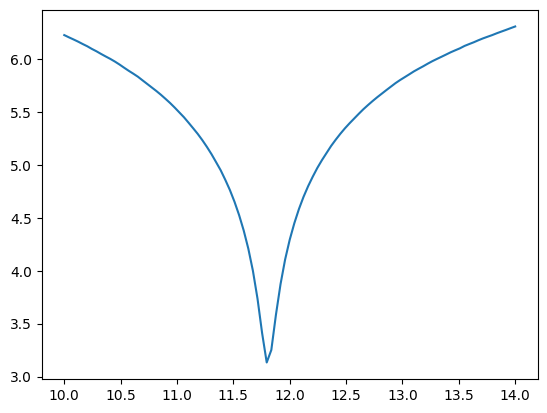

In [10]:


config_com = config_com._replace(return_snapshots=True,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )

@jit
def time_integration_x_grad(x,):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params
    new_params_com = params_com
                
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    snapshots_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)

    states_com = snapshots_com.states
    stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

    mask = stream_data[:, 1]>stream_coordinate_com[0, :, 1]
    interp_stream_track = jnp.interp(
        stream_data[:, 1], 
        stream_coordinate_com[:30, :, 1].ravel(), 
        stream_coordinate_com[:30, :, 2].ravel()
    )
    
    # Calculate residuals only for valid points
    residuals = jnp.where(mask, stream_data[:, 2] - interp_stream_track, 0.0)
    n_valid = jnp.sum(mask)  # Number of valid data points
    sigma = 0.1  # Assumed observational uncertainty
    # Gaussian log-likelihood: ln L = -0.5 * [chi2 + N*ln(2π*σ²)]
    chi2 = jnp.sum(residuals**2) / sigma**2
    log_likelihood = -0.5 * (chi2 + n_valid * jnp.log(2 * jnp.pi * sigma**2))
    
    return jnp.log10(-log_likelihood)


chi2 = time_integration_x_grad(x=11.8)
x = jnp.linspace(10., 14., 99)
chi2, grad = jax.vmap(jax.value_and_grad(time_integration_x_grad))(x)
plt.plot(x, chi2)
# plt.axvline(tend, color='r')
# plt.ylim(-10, 100)

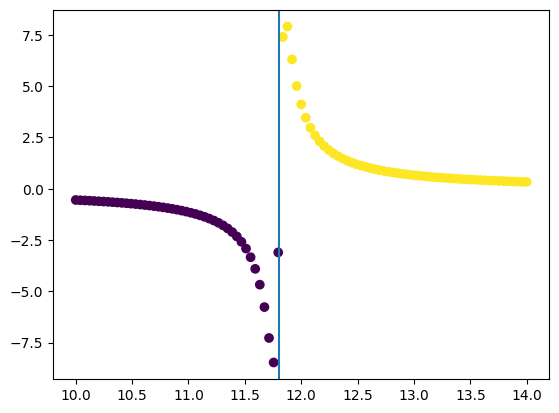

In [11]:
plt.scatter(x, grad, c=grad>0)
plt.axvline(11.8)

In [8]:
x


Array([10.       , 10.040816 , 10.081633 , 10.12245  , 10.163265 ,
       10.204082 , 10.244898 , 10.285715 , 10.32653  , 10.367347 ,
       10.408163 , 10.448979 , 10.489796 , 10.530612 , 10.571428 ,
       10.612246 , 10.653061 , 10.693878 , 10.734694 , 10.77551  ,
       10.816326 , 10.857142 , 10.897959 , 10.938775 , 10.979591 ,
       11.020408 , 11.061224 , 11.10204  , 11.142858 , 11.183674 ,
       11.22449  , 11.265306 , 11.306123 , 11.346939 , 11.387755 ,
       11.428572 , 11.469387 , 11.510204 , 11.55102  , 11.591837 ,
       11.632652 , 11.67347  , 11.714285 , 11.755101 , 11.7959175,
       11.836735 , 11.87755  , 11.918367 , 11.959183 , 12.       ,
       12.040815 , 12.081633 , 12.122448 , 12.163265 , 12.204082 ,
       12.244898 , 12.285714 , 12.32653  , 12.367347 , 12.408163 ,
       12.448979 , 12.489796 , 12.530612 , 12.571428 , 12.612245 ,
       12.653061 , 12.693877 , 12.734694 , 12.77551  , 12.816326 ,
       12.857142 , 12.897959 , 12.938774 , 12.979591 , 13.0204

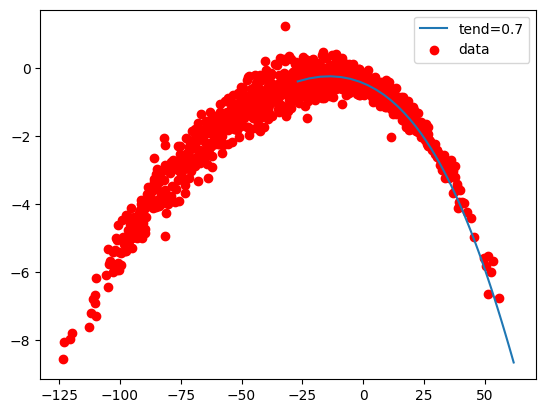

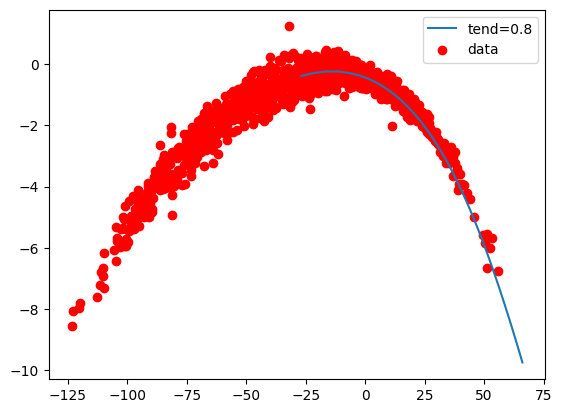

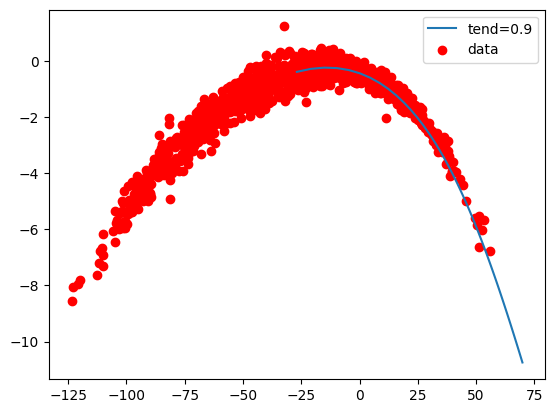

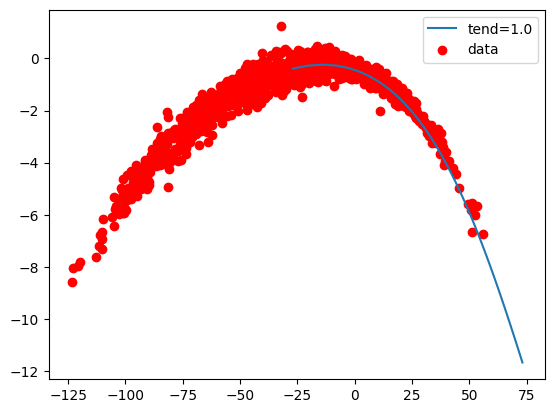

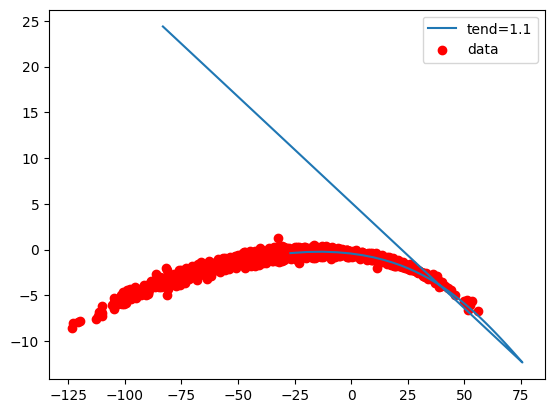

In [39]:
for tend in [0.7, 0.8, 0.9, 1.0, 1.1]:
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                t_end=tend)
    new_params_com = params._replace(
                t_end=-tend)
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    snapshots_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)

    states_com = snapshots_com.states
    stream_coordinate_com = jax.vmap(projection_on_GD1, in_axes=(0, None))(states_com, code_units)

    plt.plot(stream_coordinate_com[:50, :, 1], stream_coordinate_com[:50, :, 2], label=f'tend={tend}')
    plt.scatter(stream_data[:, 1], stream_data[:, 2], c='r', label='data')
    plt.legend()
    plt.show()
    